# $$ Q - Learning $$

## Imports

In [1]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os

# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","Q_LEANING")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\Q_LEANING'

## Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-random-10x10-plus-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
DEBUG_MODE = 0
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Q-Learning Related Constants
'''
DISCOUNT_FACTOR = 0.99

'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [4]:
def simulate(discount_factor:float= 0.99):
    """Simulate Q-Learning Algorythim .

    Args:
        discount_factor (float): gamma.

    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(learning_rate_episode_list): Numpy array with the episodes learning rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """

    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    learning_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []

    # Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)

    # Render tha maze
    env.render()

    # Initialize q_table
    q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)

    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)
        total_reward = 0


        for t in range(MAX_T):

            # Select an action
            action = epsilon_greedy_police(state_0, explore_rate,q_table)

            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            state = state_to_bucket(obv)
            total_reward += reward

            # Update the Q based on the result
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])

            # Setting up for the next iteration
            state_0 = state

            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (episode, t, total_reward, num_streaks))
                num_streaks_copy = num_streaks
                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (episode, t, total_reward))

        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        learning_rate_episode_list.append(learning_rate)
        num_streaks_episode_list.append(num_streaks_copy)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)


    print("FINAL ACTION TABLE \n")
    acts = ["N", "S", "E", "W"]
    for i in range(q_table.shape[2]):
        print(f"Action {acts[i]} table \n {q_table[:,:,i]}\n")

    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(learning_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))


## Epsilon Greed Exploration

In [5]:
def epsilon_greedy_police(state, explore_rate,q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

In [7]:
def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [8]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

In [9]:
reward_episode_array,explore_rate_episode_array,learning_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(discount_factor = DISCOUNT_FACTOR)

if ENABLE_RECORDING:
    env.monitor.close()

Episode 0 finished after 185.000000 time steps with total reward = 0.815000 (streak 0).
Episode 1 finished after 1093.000000 time steps with total reward = -0.093000 (streak 0).
Episode 2 finished after 567.000000 time steps with total reward = 0.433000 (streak 0).
Episode 3 finished after 107.000000 time steps with total reward = 0.893000 (streak 0).
Episode 4 finished after 22.000000 time steps with total reward = 0.978000 (streak 0).
Episode 5 finished after 159.000000 time steps with total reward = 0.841000 (streak 1).
Episode 6 finished after 98.000000 time steps with total reward = 0.902000 (streak 0).
Episode 7 finished after 33.000000 time steps with total reward = 0.967000 (streak 1).
Episode 8 finished after 157.000000 time steps with total reward = 0.843000 (streak 2).
Episode 9 finished after 42.000000 time steps with total reward = 0.958000 (streak 0).
Episode 10 finished after 92.000000 time steps with total reward = 0.908000 (streak 1).
Episode 11 finished after 59.00000

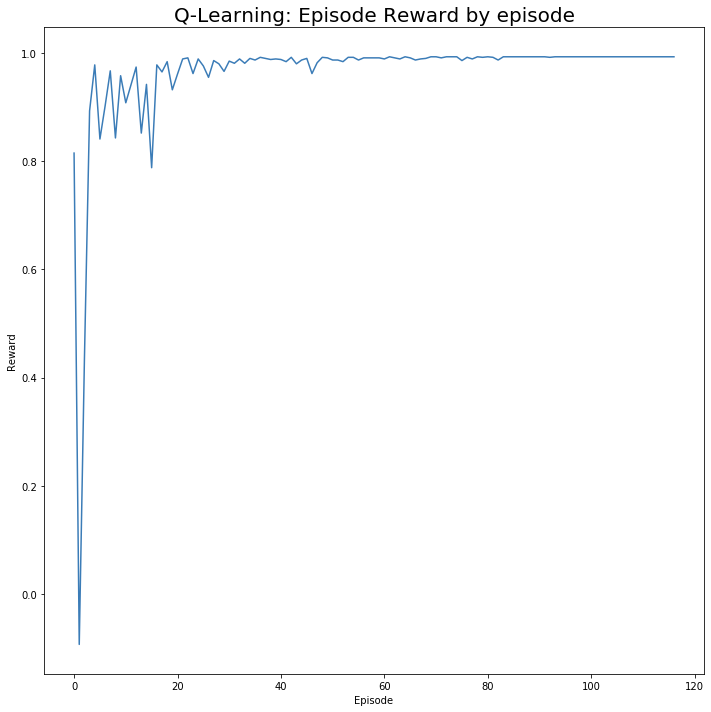

<Figure size 432x288 with 0 Axes>

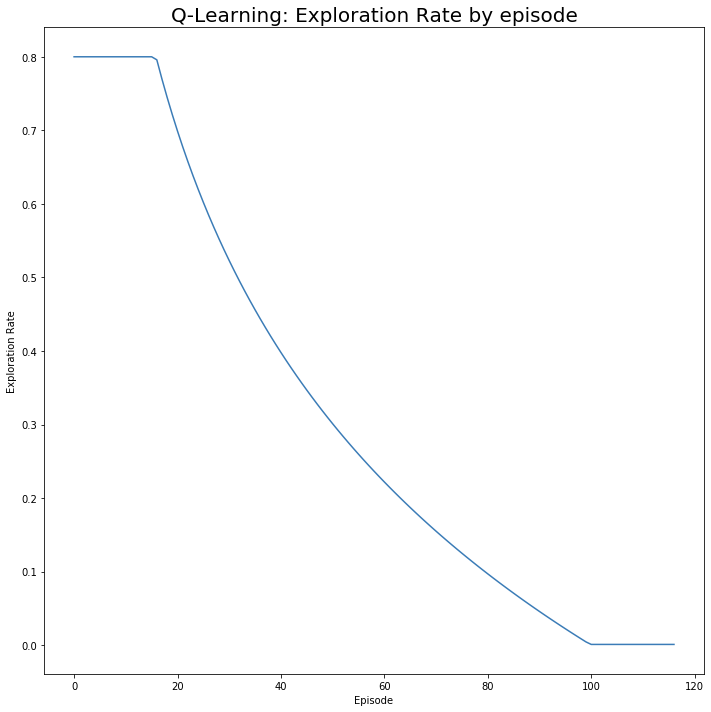

<Figure size 432x288 with 0 Axes>

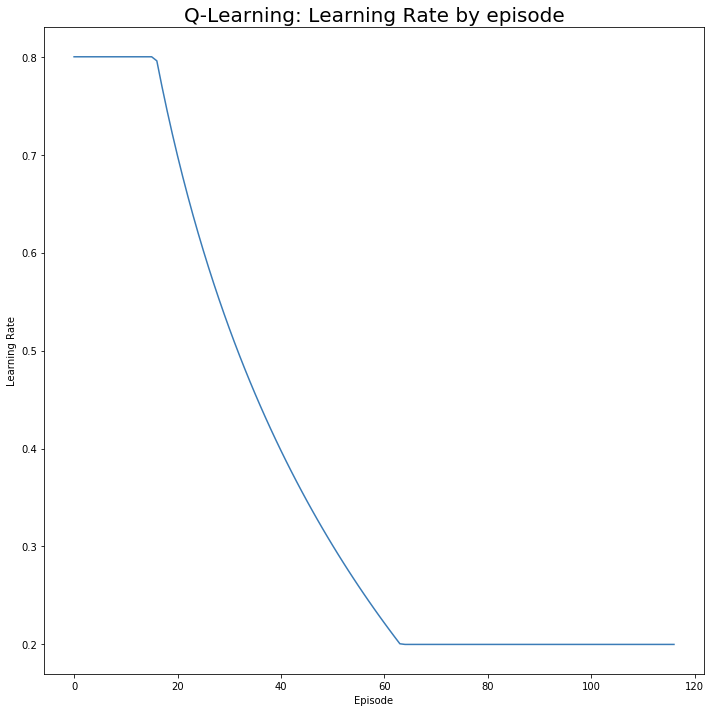

<Figure size 432x288 with 0 Axes>

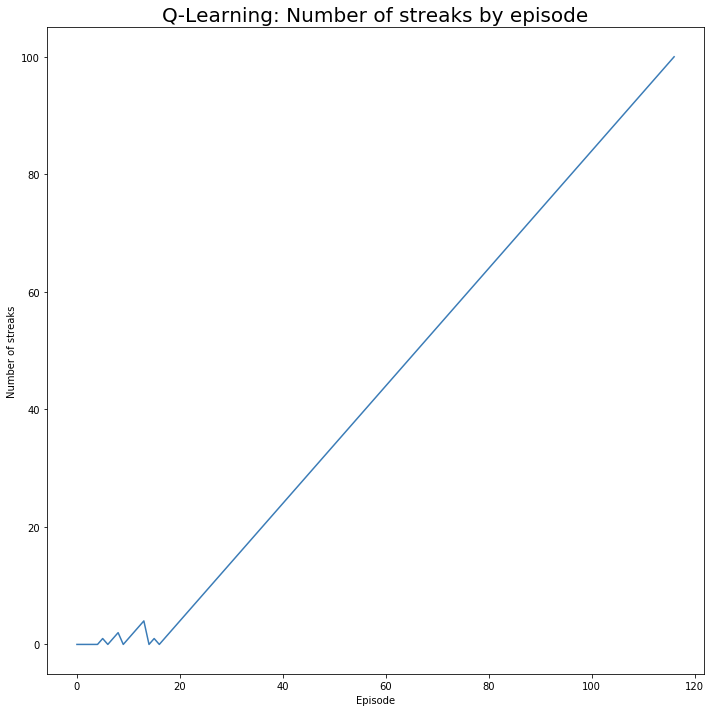

<Figure size 432x288 with 0 Axes>

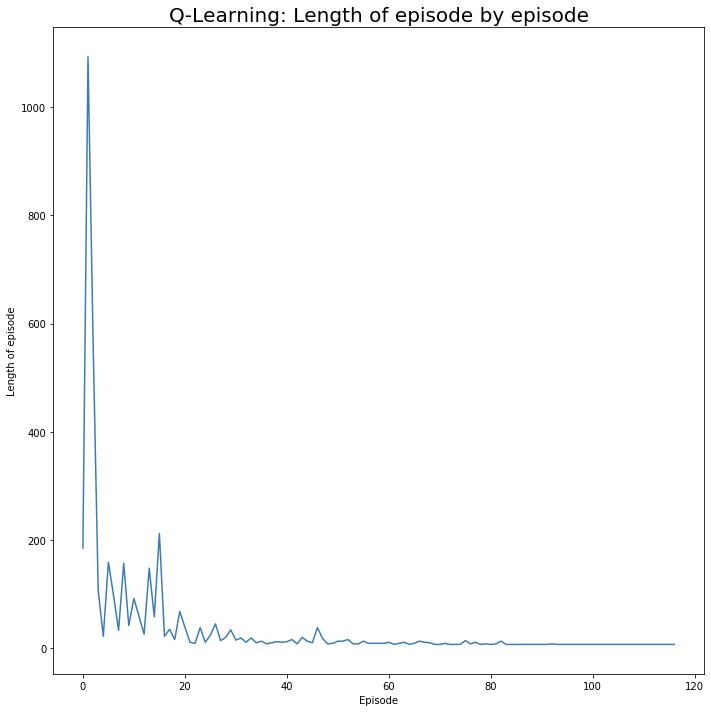

<Figure size 432x288 with 0 Axes>

In [10]:
graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Episode Reward by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [explore_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Exploration Rate",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Exploration Rate by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"learning_rate_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [learning_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Learning Rate",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Learning Rate by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [num_streaks_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Number of streaks",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Number of streaks by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [length_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Length of episode",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Length of episode by episode" ,
                            graph_saving_path = graph_saving_path)

## Saving numpy arrays from results

In [11]:
save_nparray_to_folder(reward_episode_array,SAVING_RESULTS_ARRAY_FODLER,"reward_episode")
save_nparray_to_folder(explore_rate_episode_array,SAVING_RESULTS_ARRAY_FODLER,"explore_rate")
save_nparray_to_folder(learning_rate_episode_array,SAVING_RESULTS_ARRAY_FODLER,"learning_rate")
save_nparray_to_folder(num_streaks_episode_array,SAVING_RESULTS_ARRAY_FODLER,"num_streaks")
save_nparray_to_folder(length_episode_array,SAVING_RESULTS_ARRAY_FODLER,"length_episode")

reward_episode Shape:  (117,)
explore_rate Shape:  (117,)
learning_rate Shape:  (117,)
num_streaks Shape:  (117,)
length_episode Shape:  (117,)
